In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import re
import os
import zlib
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import sys
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
Spotify = pd.read_csv('SpotifyFeatures.csv')
lyrics = pd.read_csv('only_lyrics.csv')

In [3]:
Spotify.head(1)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.91,0.0,C#,0.346,-1.828,Major,0.0525,166.969,4/4,0.814


In [4]:
lyrics.head(1)

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."


## Merging lyrics and the songs

In [5]:
Spotify['track_name']=Spotify['track_name'].str.lower()
Spotify['track_name']=Spotify['track_name'].str.strip()
Spotify['artist_name']=Spotify['artist_name'].str.lower()
Spotify['artist_name']=Spotify['artist_name'].str.strip()
lyrics['song']=lyrics['song'].str.lower()
lyrics['song']=lyrics['song'].str.strip()
lyrics['artist']=lyrics['artist'].str.lower()
lyrics['artist']=lyrics['artist'].str.strip()

In [6]:
song_lyrics = Spotify.merge(lyrics, left_on=['track_name', 'artist_name'], right_on=['song', 'artist'])  

In [7]:
song_lyrics =song_lyrics.sort_values(by=['popularity'],ascending=False)
song_lyrics = song_lyrics.reset_index()
song_lyrics.head()

,index,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,...,loudness,mode,speechiness,tempo,time_signature,valence,artist,song,link,text
0,6583,Pop,ed sheeran,photograph,1HNkqx9Ahdgi1Ixy2xkKkL,86,0.607,0.614,258987,0.379,...,-10.480,Major,0.0476,107.989,4/4,0.201,ed sheeran,photograph,/e/ed+sheeran/photograph_21058341.html,"[Verse 1] \nLoving can hurt, loving can hurt ..."
1,6570,Pop,sam smith,stay with me,5Nm9ERjJZ5oyfXZTECKmRt,85,0.588,0.418,172724,0.420,...,-6.444,Major,0.0414,84.094,4/4,0.184,sam smith,stay with me,/s/sam+smith/stay+with+me_21088932.html,"[Verse 1:] \nGuess it's true, I'm not good at..."
2,7473,Rock,toto,africa,2374M0fQpWi3dLnB54qaLX,85,0.257,0.671,295893,0.373,...,-18.064,Major,0.0323,92.717,4/4,0.732,toto,africa,/t/toto/africa_20139798.html,I hear the drums echoing tonight \nBut she he...
3,6571,Pop,jason mraz,i'm yours,1EzrEOXmMH3G43AXT1y7pA,85,0.595,0.686,242187,0.457,...,-8.322,Major,0.0468,150.953,4/4,0.718,jason mraz,i'm yours,/j/jason+mraz/im+yours_20540072.html,Well you done done me and you bet I felt it \...
4,6572,Rock,jason mraz,i'm yours,1EzrEOXmMH3G43AXT1y7pA,85,0.595,0.686,242187,0.457,...,-8.322,Major,0.0468,150.953,4/4,0.718,jason mraz,i'm yours,/j/jason+mraz/im+yours_20540072.html,Well you done done me and you bet I felt it \...


In [8]:
song_lyrics=song_lyrics.drop(['artist', 'song', 'link'], axis=1)
song_lyrics.shape

(8472, 20)

In [9]:
song_lyrics.shape

(8472, 20)

## Pre-processing lyrics

In [10]:
def clean_lyrics(lyrics):
    new_lyrics = re.sub(r'[\(\[].*?[\)\]]', '', lyrics)
    new_lyrics = new_lyrics.replace("\n", "")
    new_lyrics = os.linesep.join([s for s in new_lyrics.splitlines() if s])
    return(new_lyrics)

In [11]:
def get_compression_rate(lyrics):
    original = lyrics.encode('utf-8')
    compressed = zlib.compress(original)
    decompressed = zlib.decompress(compressed)
    
    compression_rate = (len(original)-len(compressed))/len(original)
    return compression_rate

In [12]:
#Apply clean_lyrics function to text column
song_lyrics['text'] = song_lyrics['text'].map(clean_lyrics)

#Append new column with compression rate
song_lyrics['compression_rate'] = song_lyrics['text'].map(get_compression_rate)

In [13]:
song_lyrics.head()

,index,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,...,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,text,compression_rate
0,6583,Pop,ed sheeran,photograph,1HNkqx9Ahdgi1Ixy2xkKkL,86,0.607,0.614,258987,0.379,...,E,0.0986,-10.480,Major,0.0476,107.989,4/4,0.201,"Loving can hurt, loving can hurt sometimes. ...",0.649622
1,6570,Pop,sam smith,stay with me,5Nm9ERjJZ5oyfXZTECKmRt,85,0.588,0.418,172724,0.420,...,C,0.1100,-6.444,Major,0.0414,84.094,4/4,0.184,"Guess it's true, I'm not good at a one-night...",0.653110
2,7473,Rock,toto,africa,2374M0fQpWi3dLnB54qaLX,85,0.257,0.671,295893,0.373,...,A,0.0481,-18.064,Major,0.0323,92.717,4/4,0.732,I hear the drums echoing tonight But she hear...,0.637206
3,6571,Pop,jason mraz,i'm yours,1EzrEOXmMH3G43AXT1y7pA,85,0.595,0.686,242187,0.457,...,B,0.1050,-8.322,Major,0.0468,150.953,4/4,0.718,Well you done done me and you bet I felt it I...,0.579859
4,6572,Rock,jason mraz,i'm yours,1EzrEOXmMH3G43AXT1y7pA,85,0.595,0.686,242187,0.457,...,B,0.1050,-8.322,Major,0.0468,150.953,4/4,0.718,Well you done done me and you bet I felt it I...,0.579859


In [14]:
#Drop duplicates
song_lyrics = song_lyrics.sort_values(by='popularity', ascending=False)
song_lyrics = song_lyrics.drop_duplicates(subset='track_id', keep="first")

#Keep only english songs
song_lyrics['language'] = song_lyrics['text'].map(detect)
song_lyrics = song_lyrics[song_lyrics['language'] =="en"]

NameError: name 'detect' is not defined

In [15]:
song_lyrics

,index,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,...,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,text,compression_rate
0,6583,Pop,ed sheeran,photograph,1HNkqx9Ahdgi1Ixy2xkKkL,86,0.607000,0.614,258987,0.379,...,E,0.0986,-10.480,Major,0.0476,107.989,4/4,0.201,"Loving can hurt, loving can hurt sometimes. ...",0.649622
2,7473,Rock,toto,africa,2374M0fQpWi3dLnB54qaLX,85,0.257000,0.671,295893,0.373,...,A,0.0481,-18.064,Major,0.0323,92.717,4/4,0.732,I hear the drums echoing tonight But she hear...,0.637206
3,6571,Pop,jason mraz,i'm yours,1EzrEOXmMH3G43AXT1y7pA,85,0.595000,0.686,242187,0.457,...,B,0.1050,-8.322,Major,0.0468,150.953,4/4,0.718,Well you done done me and you bet I felt it I...,0.579859
5,6577,Pop,ed sheeran,thinking out loud,34gCuhDGsG4bRPIf9bb02f,85,0.474000,0.781,281560,0.445,...,D,0.1840,-6.061,Major,0.0295,78.998,4/4,0.591,When your legs don't work like they used to ...,0.630048
1,6570,Pop,sam smith,stay with me,5Nm9ERjJZ5oyfXZTECKmRt,85,0.588000,0.418,172724,0.420,...,C,0.1100,-6.444,Major,0.0414,84.094,4/4,0.184,"Guess it's true, I'm not good at a one-night...",0.653110
6,44,Children’s Music,linkin park,in the end,60a0Rd6pjrkxjPbaKzXjfq,84,0.010300,0.542,216933,0.853,...,D#,0.1080,-6.407,Minor,0.0498,105.256,4/4,0.370,It starts with one thing I don't know why It...,0.659066
8,1568,Dance,ariana grande,one last time,7xoUc6faLbCqZO6fQEYprd,84,0.093000,0.628,197267,0.593,...,G#,0.0960,-5.036,Major,0.0323,125.026,4/4,0.104,"I was a liar, I gave into the fire I know I...",0.738082
15,6582,Rock,twenty one pilots,ride,2Z8WuEywRWYTKe1NybPQEW,83,0.008350,0.645,214507,0.713,...,F#,0.1130,-5.355,Major,0.0393,74.989,4/4,0.566,I just wanna stay in the sun where I find I...,0.701008
18,1581,Pop,train,"hey, soul sister",4HlFJV71xXKIGcU3kRyttv,83,0.185000,0.673,216773,0.886,...,C#,0.0826,-4.440,Minor,0.0431,97.012,4/4,0.795,"Hey, hey, hey Your lipstick stains on the f...",0.513305
17,6588,Pop,justin bieber,love yourself,50kpGaPAhYJ3sGmk6vplg0,83,0.856000,0.607,233720,0.376,...,E,0.2850,-9.954,Major,0.4530,102.541,4/4,0.545,For all the times that you rain on my parade...,0.730115


## Addition of classes

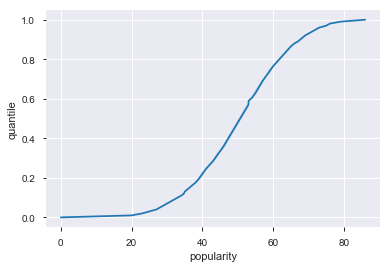

In [16]:
quantile=song_lyrics['popularity'].quantile(np.arange(0, 1.01, 0.01).tolist())
quantile=quantile.reset_index()
quantile.rename(columns={'index':'quantile'}, inplace=True)
sns.lineplot(quantile['popularity'],quantile['quantile'])

In [17]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(quantile)
quantile['cluster']=kmeans.predict(quantile)

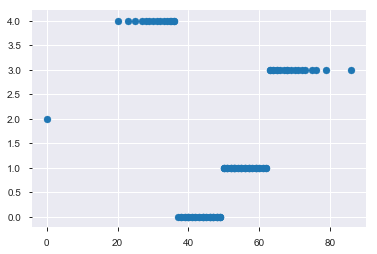

In [18]:
plt.scatter(quantile['popularity'],quantile['cluster'])

In [19]:
one=quantile[quantile.cluster==1]
two=quantile[quantile.cluster==2]
three=quantile[quantile.cluster==3]
zero=quantile[quantile.cluster==0]
four=quantile[quantile.cluster==4]
min_one=np.min(one['popularity'])
max_one=np.max(one['popularity'])
min_two=np.min(two['popularity'])
max_two=np.max(two['popularity'])
min_three=np.min(three['popularity'])
max_three=np.max(three['popularity'])
min_zero=np.min(zero['popularity'])
max_zero=np.max(zero['popularity'])
min_four=np.min(four['popularity'])
max_four=np.max(four['popularity'])
print(1,min_one,max_one)
print(2,min_two,max_two)
print(3,min_three,max_three)
print(4,min_four,max_four)
print(0,min_zero,max_zero)

1 50.0 62.0
2 0.0 0.0
3 63.0 86.0
4 20.0 36.0
0 37.0 49.0


In [20]:
conditions = [
    (song_lyrics['popularity'] >= 78)&(song_lyrics['popularity'] <=100),
    (song_lyrics['popularity'] >= 55)&(song_lyrics['popularity'] <=77),
    (song_lyrics['popularity'] >= 39)&(song_lyrics['popularity'] <=54),
    (song_lyrics['popularity'] >= 19)&(song_lyrics['popularity'] <=38),
    (song_lyrics['popularity'] >= 18)&(song_lyrics['popularity'] <=0)]
choices = [4, 3, 2,1,0]
song_lyrics['label'] = np.select(conditions, choices)
song_lyrics.head()

,index,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,...,liveness,loudness,mode,speechiness,tempo,time_signature,valence,text,compression_rate,label
0,6583,Pop,ed sheeran,photograph,1HNkqx9Ahdgi1Ixy2xkKkL,86,0.607,0.614,258987,0.379,...,0.0986,-10.480,Major,0.0476,107.989,4/4,0.201,"Loving can hurt, loving can hurt sometimes. ...",0.649622,4
2,7473,Rock,toto,africa,2374M0fQpWi3dLnB54qaLX,85,0.257,0.671,295893,0.373,...,0.0481,-18.064,Major,0.0323,92.717,4/4,0.732,I hear the drums echoing tonight But she hear...,0.637206,4
3,6571,Pop,jason mraz,i'm yours,1EzrEOXmMH3G43AXT1y7pA,85,0.595,0.686,242187,0.457,...,0.1050,-8.322,Major,0.0468,150.953,4/4,0.718,Well you done done me and you bet I felt it I...,0.579859,4
5,6577,Pop,ed sheeran,thinking out loud,34gCuhDGsG4bRPIf9bb02f,85,0.474,0.781,281560,0.445,...,0.1840,-6.061,Major,0.0295,78.998,4/4,0.591,When your legs don't work like they used to ...,0.630048,4
1,6570,Pop,sam smith,stay with me,5Nm9ERjJZ5oyfXZTECKmRt,85,0.588,0.418,172724,0.420,...,0.1100,-6.444,Major,0.0414,84.094,4/4,0.184,"Guess it's true, I'm not good at a one-night...",0.653110,4


In [21]:
song_lyrics

,index,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,...,liveness,loudness,mode,speechiness,tempo,time_signature,valence,text,compression_rate,label
0,6583,Pop,ed sheeran,photograph,1HNkqx9Ahdgi1Ixy2xkKkL,86,0.607000,0.614,258987,0.379,...,0.0986,-10.480,Major,0.0476,107.989,4/4,0.201,"Loving can hurt, loving can hurt sometimes. ...",0.649622,4
2,7473,Rock,toto,africa,2374M0fQpWi3dLnB54qaLX,85,0.257000,0.671,295893,0.373,...,0.0481,-18.064,Major,0.0323,92.717,4/4,0.732,I hear the drums echoing tonight But she hear...,0.637206,4
3,6571,Pop,jason mraz,i'm yours,1EzrEOXmMH3G43AXT1y7pA,85,0.595000,0.686,242187,0.457,...,0.1050,-8.322,Major,0.0468,150.953,4/4,0.718,Well you done done me and you bet I felt it I...,0.579859,4
5,6577,Pop,ed sheeran,thinking out loud,34gCuhDGsG4bRPIf9bb02f,85,0.474000,0.781,281560,0.445,...,0.1840,-6.061,Major,0.0295,78.998,4/4,0.591,When your legs don't work like they used to ...,0.630048,4
1,6570,Pop,sam smith,stay with me,5Nm9ERjJZ5oyfXZTECKmRt,85,0.588000,0.418,172724,0.420,...,0.1100,-6.444,Major,0.0414,84.094,4/4,0.184,"Guess it's true, I'm not good at a one-night...",0.653110,4
6,44,Children’s Music,linkin park,in the end,60a0Rd6pjrkxjPbaKzXjfq,84,0.010300,0.542,216933,0.853,...,0.1080,-6.407,Minor,0.0498,105.256,4/4,0.370,It starts with one thing I don't know why It...,0.659066,4
8,1568,Dance,ariana grande,one last time,7xoUc6faLbCqZO6fQEYprd,84,0.093000,0.628,197267,0.593,...,0.0960,-5.036,Major,0.0323,125.026,4/4,0.104,"I was a liar, I gave into the fire I know I...",0.738082,4
15,6582,Rock,twenty one pilots,ride,2Z8WuEywRWYTKe1NybPQEW,83,0.008350,0.645,214507,0.713,...,0.1130,-5.355,Major,0.0393,74.989,4/4,0.566,I just wanna stay in the sun where I find I...,0.701008,4
18,1581,Pop,train,"hey, soul sister",4HlFJV71xXKIGcU3kRyttv,83,0.185000,0.673,216773,0.886,...,0.0826,-4.440,Minor,0.0431,97.012,4/4,0.795,"Hey, hey, hey Your lipstick stains on the f...",0.513305,4
17,6588,Pop,justin bieber,love yourself,50kpGaPAhYJ3sGmk6vplg0,83,0.856000,0.607,233720,0.376,...,0.2850,-9.954,Major,0.4530,102.541,4/4,0.545,For all the times that you rain on my parade...,0.730115,4


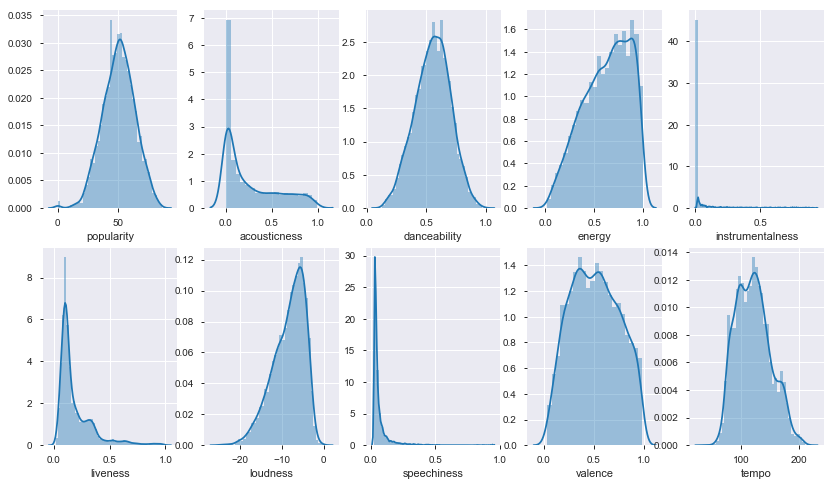

In [22]:
f, axes = plt.subplots(2, 5, figsize=(14, 8), sharex=False)
sns.distplot(song_lyrics['popularity'],ax=axes[0,0])
sns.distplot(song_lyrics['acousticness'],ax=axes[0,1])
sns.distplot(song_lyrics['danceability'],ax=axes[0,2])
sns.distplot(song_lyrics['energy'],ax=axes[0,3])
sns.distplot(song_lyrics['instrumentalness'],ax=axes[0, 4])
sns.distplot(song_lyrics['liveness'],ax=axes[1,0])
sns.distplot(song_lyrics['loudness'],ax=axes[1,1])
sns.distplot(song_lyrics['speechiness'],ax=axes[1,2])
sns.distplot(song_lyrics['valence'],ax=axes[1,3])
sns.distplot(song_lyrics['tempo'],ax=axes[1,4])